# Convolutional Neural Network (CNN)

## Business Problem

This project involves developing an automatic landscape classifier. The dataset is available at the following link under the names "seg_train.zip" and "seg_test.zip" (or via the download button):

[Intel Image Classification Dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification?select=seg_test)

Note: These files are quite large (a total of 386MB). Once the analysis is completed, it is not necessary to keep them on the local machine and they can be deleted if required.

In [1]:
import os
import sys
import zipfile

import cv2
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from skimage.io import imread
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.utils import shuffle
from tensorflow import keras
# from tensorflow.keras import layers

# add "src" path
root_path = os.path.abspath(os.path.join(os.getcwd(), '..')) 
if os.path.exists(root_path) and root_path not in sys.path: 
    sys.path.append(root_path)

from utils.functions import show_images_batch

# Import whole class and then access using fully qualified names
# from keras._tf_keras import keras

In [2]:
tf.__version__

'2.18.0'

In [3]:
np.__version__

'2.0.2'

## Loading the Images

Before proceeding with model training, it is essential to examine how the dataset is structured. The images need to be loaded into memory while preserving their corresponding labels, which are derived from the folder names. Additionally, each image should be reshaped to a uniform size—starting with 32x32 pixels to accelerate the initial executions.

Steps to Follow:
1. Download the images from the Kaggle repository into the designated working directory.
2. Extract the dataset (which consists of image files) so that two subdirectories, seg_train and seg_test, are created. These should contain subfolders corresponding to each landscape category. If seg_pred was also downloaded, it can be deleted as it is not required.
3. Define key variables to manage file paths and dataset loading, adapting them to the specific directory structure being used.
4. Create X_train, y_train y X_test e y_test.

In [4]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is F616-7494

 Directory of c:\Users\Lander\Documents\GitHub\deep_learning_images\src\notebooks

01/30/2025  00:00    <DIR>          .
01/29/2025  23:43    <DIR>          ..
01/30/2025  13:35         2,056,565 nb01_cnn_landscapes.ipynb
               1 File(s)      2,056,565 bytes
               2 Dir(s)  137,184,546,816 bytes free


In [5]:
# Create directory
!mkdir ..\data


A subdirectory or file ..\data already exists.


In [6]:
# Extract files
path_to_zip_file = "../data/archive.zip"
directory_to_extract_to = "../data/"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

Now, a function will be created to read images from the directories and generate both X (features) and y (labels).

In [7]:
ROOT_PATH = "../data/"
TRAIN_PATH = ROOT_PATH + "seg_train/seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/seg_test/"


In [8]:
def read_landscapes_data(directorio, reshape_dim=(32, 32)):
    """
    Reads image data from a directory and resizes each image to the specified dimensions.
    """
    X = []
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                # Reshape images to 32x32
                image = cv2.resize(image, reshape_dim) 

                X.append(image)
                y.append(folder)

    return np.array(X), np.array(y)

In [9]:
print("Reading training data...")
X_train, y_train = read_landscapes_data(TRAIN_PATH)

# Note: The creation of X_test could be deferred until it is needed, 
# allowing for memory optimization while it is not in use.
print("\nReading test data...")
X_test, y_test = read_landscapes_data(TEST_PATH) 


Reading training data...
buildings
forest
glacier
mountain
sea
street

Reading test data...
buildings
forest
glacier
mountain
sea
street


In [10]:
X_train.shape

(14034, 32, 32, 3)

In [11]:
type(X_train)

numpy.ndarray

To save time in the future and reduce storage space, the numpy.ndarray objects will be stored locally.

In [12]:
# Guardar las variables en archivos separados
np.save("../data/X_train.npy", X_train)
np.save("../data/y_train.npy", y_train)
np.save("../data/X_test.npy", X_test)
np.save("../data/y_test.npy", y_test)


> If reloading the images is not required, start execution from this point onward.

In [13]:
# Cargar las variables guardadas
X_train = np.load("../data/X_train.npy")
y_train = np.load("../data/y_train.npy")
X_test = np.load("../data/X_test.npy")
y_test = np.load("../data/y_test.npy")

In [14]:
X_train.shape

(14034, 32, 32, 3)

> These are color tensors (3D - RGB).

## Visualize the dataset

Check the number of samples, their shape, explore the images, and verify with some samples that the data has been loaded correctly.


In [15]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)

X_train shape:  (14034, 32, 32, 3)
y_train shape:  (14034,)


14034 images of 32x32 with 3 color channels in the training set.

In [16]:
print('X_test shape: ', X_test.shape)
print('y_text shape: ', y_test.shape)

X_test shape:  (3000, 32, 32, 3)
y_text shape:  (3000,)


3000 images in the test set.

## Image plotting

We will use an image plotting function developed for this project.

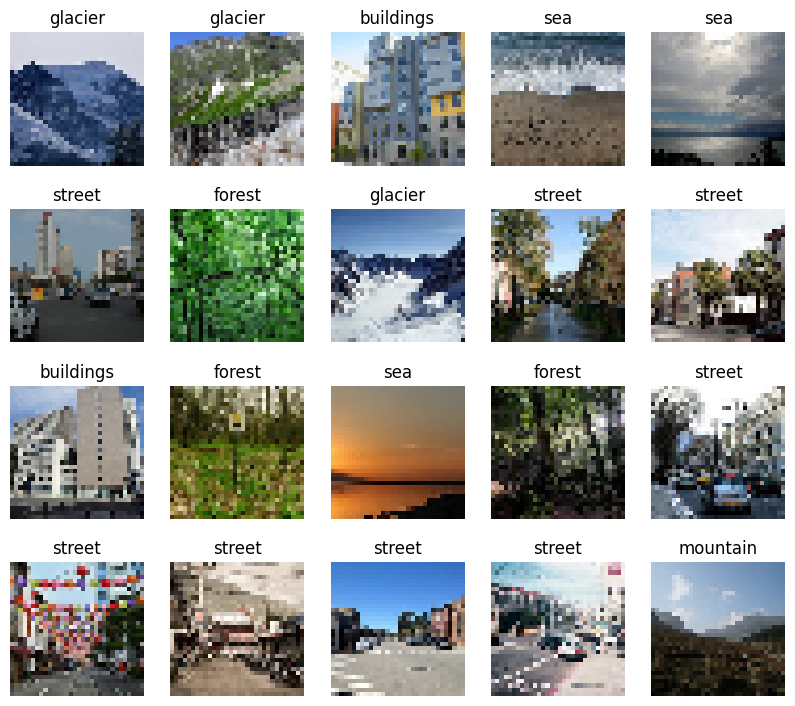

In [17]:
indexes = np.random.randint(0, len(X_train), 20)
show_images_batch(X_train[indexes], 
                  titles=y_train[indexes], 
                  n_cols=5)

To our eyes, the resolution reduction has an impact. If you want, you can change the resolution and test it, but keep in mind that it will come at the cost of increased computation time.


## Mini-EDA

Now, we will perform a brief mini-EDA and normalize the features.

Let's analyze the distribution of each landscape type.


In [18]:
pd.Series(y_train).value_counts(normalize=True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

We need to build a multiclass classifier with six possible classes. The dataset is relatively balanced, though there is a slight predominance of mountain landscapes compared to buildings.

Now, a classic step in image normalization: dividing by 255. This is done to scale pixel values from the original [0, 255] range to [0, 1], improving model convergence and stability during training.

In [19]:
# Normalization
X_train = X_train / 255
X_test = X_test / 255

Remember that normalization is beneficial even when the features are already in the same scale. On one hand, activation functions tend to perform better in ranges between -1 and 1 (especially tanh, sigmoid, etc.). On the other hand, high input values can negatively affect the gradient descent process during backpropagation, making optimization less efficient.

## Network Architecture Design

Remember that this is a classification algorithm. Pay attention to the input dimensions. We will create a structure similar to the one in the figure below (a couple of Conv2D + MaxPooling2D layers with ReLU activation, followed by the fully connected layer), though with some modifications.

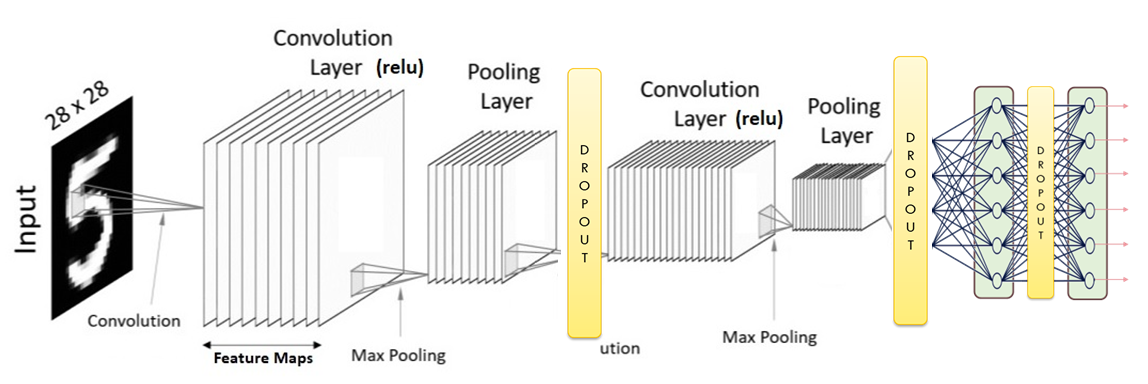


In [20]:
X_train[0].shape

(32, 32, 3)

In [21]:
# First, we define the layers of the network. In this case, we start with 30 filters of size 3x3, 
# followed by a 2x2 pooling layer and a 25% Dropout.
# The input shape is the size of the input images, in our case 32x32x3.
# The kernel size is small but typical for such low resolutions, 
# and the number of filters is chosen accordingly.

layers = [
    # Input layer
    keras.layers.Input(shape=X_train[0].shape),
    
    # First convolutional layer, pooling, and dropout
    keras.layers.Conv2D(filters=30,
                        kernel_size=(3, 3),
                        padding="same", 
                        activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2, 2),
                           strides=(2, 2)),
    keras.layers.Dropout(rate=0.25),
    
    # Second convolutional layer, pooling, and dropout
    keras.layers.Conv2D(filters=15,
                        kernel_size=(3, 3),
                        padding="same",
                        activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2),
                              strides=(2, 2)),
    keras.layers.Dropout(rate=0.25),
    
    # Flatten the output of the convolutional layers
    keras.layers.Flatten(),
    
    # First dense layer for classification, with additional dropout
    keras.layers.Dense(units=150, 
                       activation="relu"),
    keras.layers.Dropout(rate=0.25),
    
    # Second dense layer for classification, with additional dropout
    keras.layers.Dense(units=100, 
                       activation="relu"),
    keras.layers.Dropout(rate=0.25),
    
    # Output layer with 6 neurons, one for each class
    keras.layers.Dense(units=6, 
                       activation="softmax")
]

# Create the model
model = keras.models.Sequential(layers=layers)


## Choose Hyperparameters and Compile the Model

In this step, we will select the remaining hyperparameters such as the optimizer, learning rate, loss function, and evaluation metrics. 

The choice of the optimizer will be based on the dataset size. After selecting these parameters, we will compile the model and display a summary of its architecture.


In [22]:
# 14034 train set pictures
X_train.shape 

(14034, 32, 32, 3)

In [23]:
X_train.size

43112448

For this task, given the size of the dataset, we will use the Adam optimizer, as its default hyperparameters generally perform well across various deep learning tasks. Considering the size of the dataset, Adam is a suitable choice due to its adaptive learning rate properties.

Since the target is one-dimensional, we will use sparse_categorical_crossentropy as the loss function, which is ideal for multi-class classification with integer labels. For evaluation, we will use accuracy, as it is the most appropriate metric, given the balanced nature of the classes.


In [24]:
model.compile(optimizer="adam", 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"]
              )

In [25]:
# Show model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 30)     │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 15)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │       144,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,761 (643.60 KB)

 Trainable params: 164,761 (643.60 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model with Validation and Callbacks

To begin with, we need to prepare the target variable (y) by converting it into integers, as the model expects numerical labels for classification tasks. After that, we will reserve 20% of the training data for validation and use the necessary callbacks for monitoring the training process.

In [26]:
pd.Series(y_train).unique()

array(['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'],
      dtype=object)

In [27]:
# Create a mapping of target labels to indices
label_map = {label: index for index, label in enumerate(pd.Series(y_train).unique())}
label_map


{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [28]:
y_train_num = np.array([label_map[y] for y in y_train])
y_test_num = np.array([label_map[y] for y in y_test])

In [29]:
y_train_num[0:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Shuffle the Data

WARNING: the data is ordered, so we need to shuffle it.

In [30]:
# Shuffle the data to prevent the model from learning the order of images
X_train, y_train_num = shuffle(X_train, y_train_num)

In [31]:
# We want to restore the best weights from the best epoch during the patience period
cb_earlystopping = keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=10, 
                                                 restore_best_weights=True)

# Train the model
history = model.fit(x=X_train,
                    y=y_train_num,
                    batch_size=32,
                    epochs=100,
                    validation_split=0.2,
                    callbacks=[cb_earlystopping])


Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.3641 - loss: 1.5075 - val_accuracy: 0.6199 - val_loss: 1.0219
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6005 - loss: 1.0170 - val_accuracy: 0.6619 - val_loss: 0.8905
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6500 - loss: 0.9170 - val_accuracy: 0.6904 - val_loss: 0.8191
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6865 - loss: 0.8291 - val_accuracy: 0.6943 - val_loss: 0.8224
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7113 - loss: 0.7725 - val_accuracy: 0.7314 - val_loss: 0.7362
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7356 - loss: 0.7287 - val_accuracy: 0.7488 - val_loss: 0.6879
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7453 - loss: 0.6872 - val_accuracy: 0.7688 - val_loss: 0.6634
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7697 - loss: 0.6381 - val_accu

## Plot and Analyze Training History


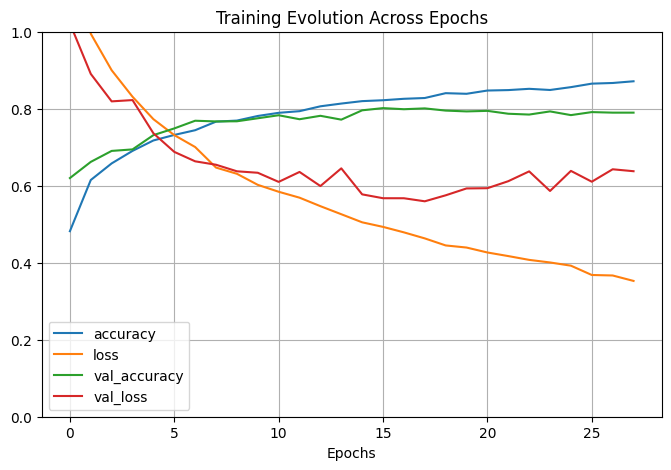

In [32]:
# Convert history to DataFrame and plot it
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel("Epochs")
plt.title("Training Evolution Across Epochs")
plt.show()


> Plot Loss and Metric Separately

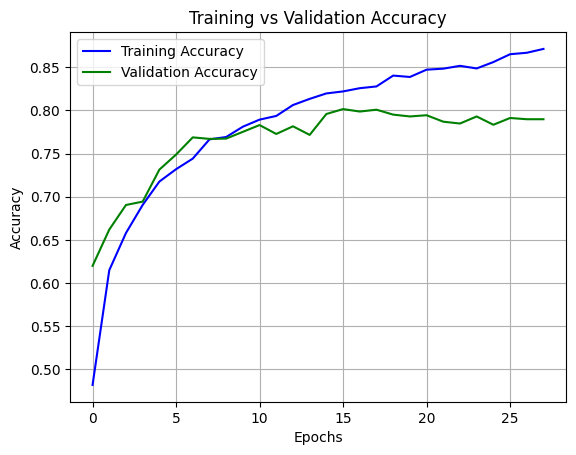

In [33]:
# Plotting the training and validation accuracy
history_df = pd.DataFrame(history.history)

plt.plot(history_df['accuracy'], label="Training Accuracy", color="blue")
plt.plot(history_df['val_accuracy'], label="Validation Accuracy", color="green")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


> Plot Training and Validation Loss

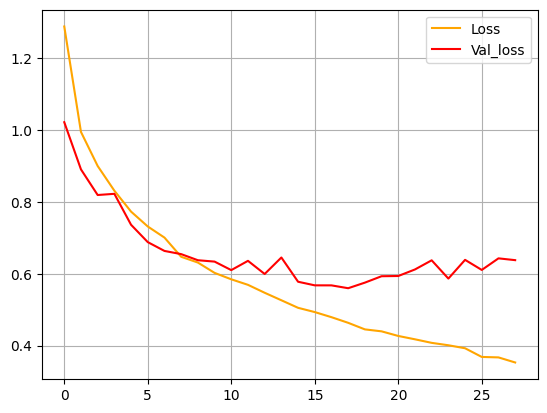

In [34]:
# Plotting the training and validation loss
plt.plot(history_df['loss'], label="Loss", color="orange")
plt.plot(history_df['val_loss'], label="Val_loss", color="red")
plt.grid(True)
plt.legend()
plt.show()

In both figures, it can be seen that after the first 5-6 epochs, the model begins to overfit. Beyond 10 epochs, the validation error starts increasing, while the training error continues to decrease. This suggests that the model is starting to memorize the training data rather than generalize well to unseen data. This behavior typically indicates the need for early stopping or further adjustments, such as regularization or reducing model complexity to prevent overfitting.


## Evaluate model

Evaluate the model on the test data, and also display the classification report and confusion matrix.

In [35]:
model.evaluate(X_test, y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7860 - loss: 0.6562


[0.5952341556549072, 0.7996666431427002]

An accuracy of 79 %, which translates to the following report:


In [36]:
y_pred = [np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [37]:
inverse_map = {valor: clave for clave, valor in label_map.items()}

y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]

print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.76      0.71      0.73       437
      forest       0.91      0.93      0.92       474
     glacier       0.78      0.75      0.77       553
    mountain       0.75      0.81      0.78       525
         sea       0.78      0.79      0.79       510
      street       0.82      0.80      0.81       501

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000



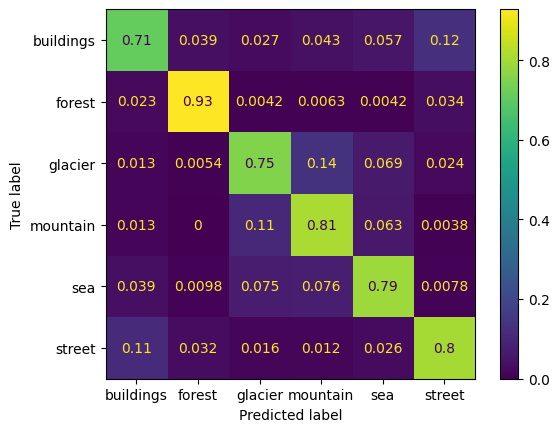

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test_labels,
                                        y_pred_labels, 
                                        normalize="true")

There is an interesting rectangle in the center of the confusion matrix, where glaciers (the worst detected landscapes) are mainly confused with mountains, although mountains are recognized fairly well. The sea also gets confused when misclassified as mountains. This leads to a decrease in the precision of the mountain class. The best classified categories are forests, followed by streets. Buildings are also poorly classified and, as expected, they get confused with streets.


## Errors

Represent some of the landscapes where the model makes errors and display the confidence it had in those predictions.


In [39]:
confidence = [prediction.max() for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [40]:
pred_df = pd.DataFrame({"True": y_test_labels, "Predicted": y_pred_labels, "Confidence": confidence})

In [41]:
error = pred_df["True"] != pred_df["Predicted"]
df_errors = pred_df[error].sort_values("Confidence", ascending=False)
df_errors

,True,Predicted,Confidence
79,buildings,forest,0.999153
1046,glacier,sea,0.998979
1260,glacier,sea,0.998676
1904,mountain,sea,0.998500
65,buildings,street,0.997820
...,...,...,...
279,buildings,sea,0.285600
1519,mountain,glacier,0.282268
937,glacier,sea,0.277794
965,glacier,street,0.276911


In [42]:
for true_label, predicted_label in df_errors.iloc[0:10, 0:2].values:
    print(true_label, ':', predicted_label)

buildings : forest
glacier : sea
glacier : sea
mountain : sea
buildings : street
buildings : street
street : forest
glacier : buildings
buildings : street
sea : buildings


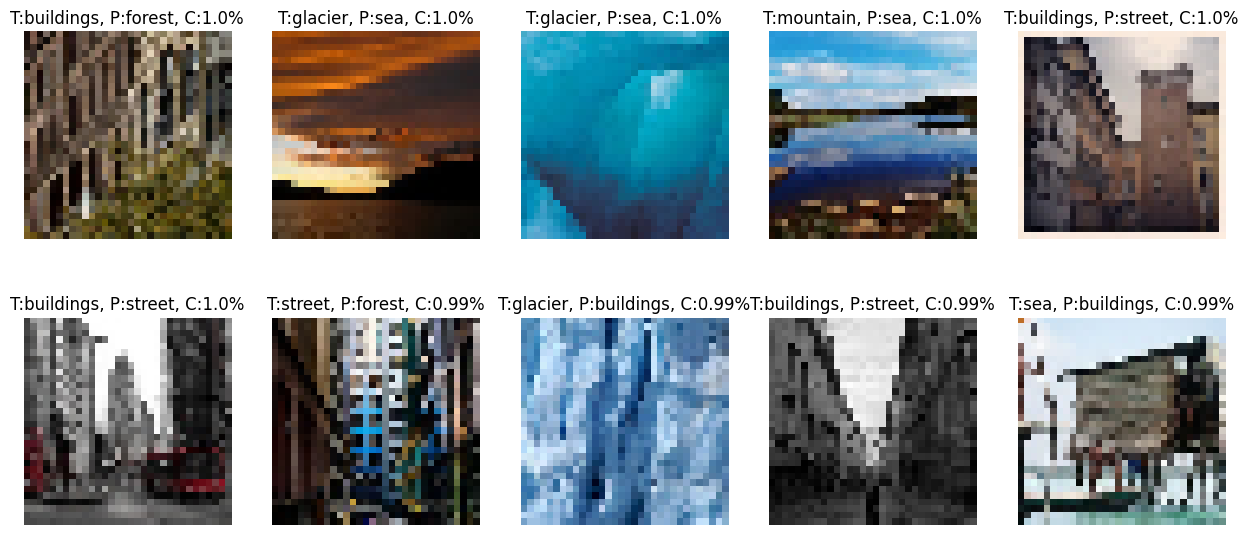

In [43]:
show_images_batch(X_test[df_errors.iloc[0:10].index],
                  titles=[f"T:{val1}, P:{val2}, C:{round(val3,2)}%" for val1, val2, val3 in df_errors.iloc[0:10].values], 
                  size_scale=3.1)

### High Resolution

In this section, we will increase the resolution of the input images and repeat the previous task using the same network topology. This will help evaluate how the model's performance changes with higher resolution images, which may provide more detailed information for the model to learn from.

In [44]:
print("Reading training data...")
X_train, y_train = read_landscapes_data(TRAIN_PATH, (64, 64))

# Note: The creation of X_test could be deferred until it is needed, 
# allowing for memory optimization while it is not in use.
print("\nReading test data...")
X_test, y_test = read_landscapes_data(TEST_PATH, (64, 64)) 

Reading training data...
buildings
forest
glacier
mountain
sea
street

Reading test data...
buildings
forest
glacier
mountain
sea
street


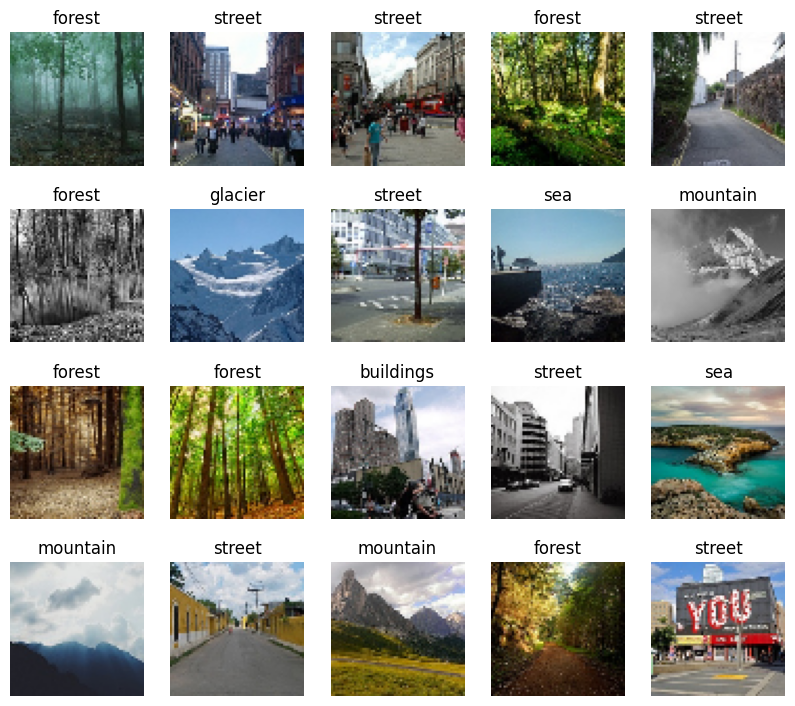

In [45]:
indexes = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indexes], 
                  titles=y_train[indexes], 
                  n_cols=5)

Certainly, the images are much sharper than before.

In [46]:
# Convert the target to numeric
y_train_num = np.array([label_map[y] for y in y_train])
y_test_num = np.array([label_map[y] for y in y_test])

# Shuffle the data
X_train, y_train_num = shuffle(X_train, y_train_num)

In [47]:
# Same model than previously
layers = [
    # Input layer
    keras.layers.Input(shape=X_train[0].shape),
    
    # First convolutional layer, pooling, and dropout
    keras.layers.Conv2D(filters=30,
                        kernel_size=(3, 3),
                        padding="same", 
                        activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2, 2),
                           strides=(2, 2)),
    keras.layers.Dropout(rate=0.25),
    
    # Second convolutional layer, pooling, and dropout
    keras.layers.Conv2D(filters=15,
                        kernel_size=(3, 3),
                        padding="same",
                        activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2),
                              strides=(2, 2)),
    keras.layers.Dropout(rate=0.25),
    
    # Flatten the output of the convolutional layers
    keras.layers.Flatten(),
    
    # First dense layer for classification, with additional dropout
    keras.layers.Dense(units=150, 
                       activation="relu"),
    keras.layers.Dropout(rate=0.25),
    
    # Second dense layer for classification, with additional dropout
    keras.layers.Dense(units=100, 
                       activation="relu"),
    keras.layers.Dropout(rate=0.25),
    
    # Output layer with 6 neurons, one for each class
    keras.layers.Dense(units=6, 
                       activation="softmax")
]

# Create the model
model = keras.models.Sequential(layers=layers)

# Compile
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 30)     │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 30)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 15)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 150)            │       576,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        15,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 596,761 (2.28 MB)

 Trainable params: 596,761 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# We want to recover the weights of the best epoch during the patience period
cb_earlystopping = keras.callbacks.EarlyStopping(monitor="val_loss",
                                                 patience=10,
                                                 restore_best_weights=True)

# Trains the model
history = model.fit(x=X_train,
                    y=y_train_num,
                    batch_size=32,
                    epochs=100,
                    validation_split=0.2,
                    callbacks=[cb_earlystopping])


Epoch 1/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2304 - loss: 9.3706 - val_accuracy: 0.3826 - val_loss: 1.5124
Epoch 2/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.3966 - loss: 1.4771 - val_accuracy: 0.4514 - val_loss: 1.3803
Epoch 3/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4941 - loss: 1.2353 - val_accuracy: 0.5668 - val_loss: 1.1332
Epoch 4/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5523 - loss: 1.1144 - val_accuracy: 0.6074 - val_loss: 1.0336
Epoch 5/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5896 - loss: 1.0363 - val_accuracy: 0.5778 - val_loss: 1.0723
Epoch 6/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6007 - loss: 1.0284 - val_accuracy: 0.6263 - val_loss: 1.0037
Epoch 7/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6228 - loss: 0.9606 - val_accuracy: 0.6046 - val_loss: 1.0619
Epoch 8/100
351/351 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6435 - loss: 0.9149 - 

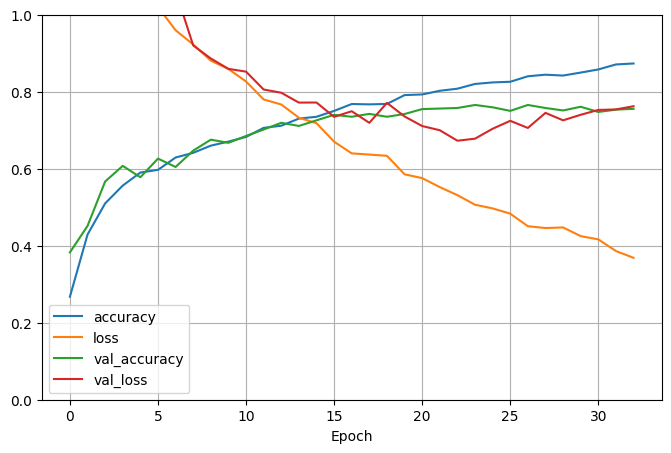

In [49]:
# We can observe how the training evolves over epochs
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel('Epoch')
plt.show()

In [50]:
model.evaluate(X_test, y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7634 - loss: 0.6850


[0.7114191651344299, 0.753333330154419]

Despite increasing the resolution and tweaking the network, the performance is worse... We should experiment with more hyperparameters or possibly make the network deeper.


In [51]:
y_pred = [np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


In [52]:
inverse_map = {valor:clave for clave,valor in label_map.items()}

y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]

print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.73      0.68      0.70       437
      forest       0.85      0.96      0.90       474
     glacier       0.69      0.80      0.74       553
    mountain       0.72      0.67      0.70       525
         sea       0.74      0.65      0.69       510
      street       0.81      0.75      0.78       501

    accuracy                           0.75      3000
   macro avg       0.76      0.75      0.75      3000
weighted avg       0.75      0.75      0.75      3000



In [53]:
confidence = [prediction.max() for prediction in model.predict(X_test)]
pred_df = pd.DataFrame({"True": y_test_labels, "Predicted": y_pred_labels, "Confidence": confidence})

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [54]:
error = pred_df["True"] != pred_df["Predicted"]
df_errors = pred_df[error].sort_values("Confidence", ascending = False)
df_errors

,True,Predicted,Confidence
79,buildings,forest,0.999999
1136,glacier,sea,0.999825
2319,sea,buildings,0.999680
88,buildings,street,0.999425
2921,street,buildings,0.998910
...,...,...,...
684,forest,sea,0.223876
2635,street,sea,0.218565
2082,sea,mountain,0.206792
2545,street,glacier,0.204945


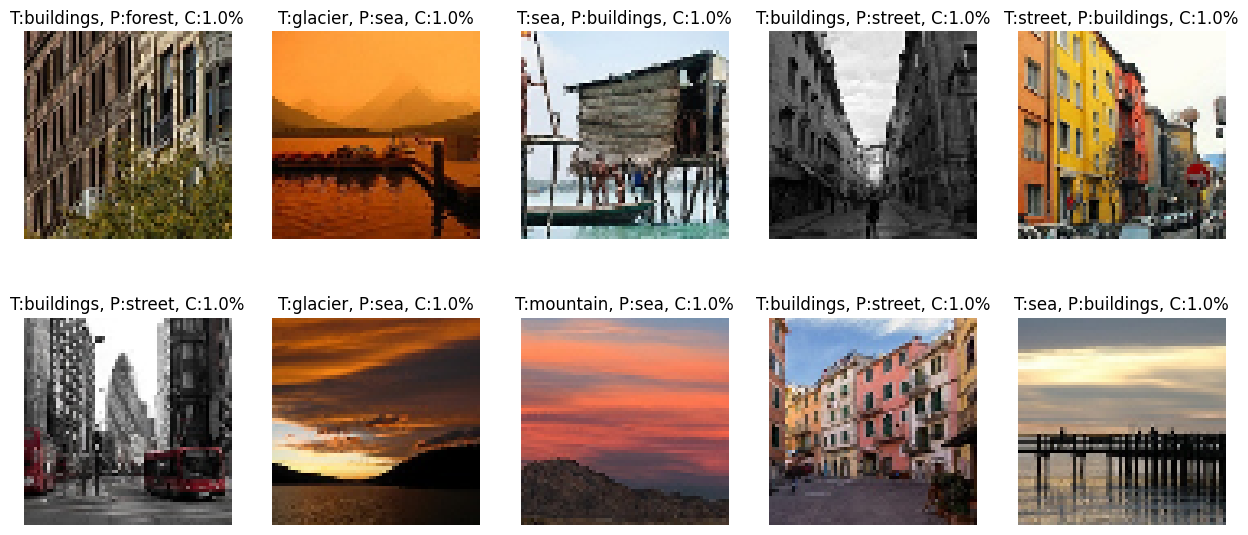

In [55]:
show_images_batch(X_test[df_errors.iloc[0:10].index],
                  titles=[f"T:{val1}, P:{val2}, C:{round(val3,2)}%" for val1,val2,val3 in df_errors.iloc[0:10].values], 
                  size_scale=3.1)

Sometimes one wonders if the labels are incorrectly assigned...